In [1]:
%load_ext autoreload

%autoreload 2


import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")


from glob import glob
import os
import pickle
from functools import partial  # pylint: disable=g-importing-member
import os
import pickle
import time
import jax
from jax import jit
from jax import random
from jax import vmap
import jax.numpy as jnp
import ml_collections
import numpy as np
import tensorflow as tf
import diffusion
import ode_datasets
import samplers
import unet
from oil.logging.lazyLogger import LazyLogger
from oil.utils.utils import FixedNumpySeed
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

2022-12-04 20:29:51.536963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 20:29:51.645534: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-04 20:29:52.056721: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.4/lib64::/home/marc/anaconda3/envs/gr/include/:/lib/:/home/marc/.mujoco/mujoco200/bin

In [92]:
base_path = './all_datasets2'#'./all_datasets4_noic'#'./all_datasets2'
run_path = 'trial2'#'trial4'
obj_name = 'config'
state = []
for name in ['config','data_std','params']:
    with open(os.path.join(base_path,run_path,name), 'rb') as f:
        state.append(pickle.load(f))
    
config, data_std, params = state

In [93]:
config

attention: false
bs: 500
channels: 32
dataset: FitzHughDataset
dataset_timesteps: 60
difftype: VarianceExploding
ds: 4000
epochs: 10000
ic_conditioning: false
log_dir: all_datasets2
log_suffix: trial2/
lr: 0.0001
noisetype: Identity
seed: 37
study_name: all_datasets2

In [94]:
key = random.PRNGKey(config.seed)
# Construct the dataset
timesteps = config.dataset_timesteps
with FixedNumpySeed(config.seed):
    ds = getattr(ode_datasets, config.dataset)(N=config.bs)
trajectories = ds.Zs[:config.bs, :timesteps]
test_x = ds.Zs[:config.bs, :timesteps]
#data_std = trajectories.std()
T_long = ds.T_long[:timesteps]  # pylint: disable=invalid-name
dataset = tf.data.Dataset.from_tensor_slices(trajectories)
dataiter = dataset.shuffle(len(dataset)).batch(config.bs).as_numpy_iterator
assert trajectories.shape[1] == timesteps, "inconsistent data sizes"

# initialize the model
x = test_x  # (bs, N, C)
modelconfig = unet.unet_64_config(
  x.shape[-1], base_channels=config.channels, attention=config.attention)
model = unet.UNet(modelconfig)
noise = getattr(diffusion, config.noisetype)
diff = getattr(diffusion, config.difftype)(noise)
# whether or not to condition on initial timesteps
cond_fn = lambda z: (z[:, :3] if config.ic_conditioning else None)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.81it/s]


In [95]:
from diffusion import unsqueeze_like
def score(params,
            x,
            t,
            train = True,
            cond = None):
    """Score function with appropriate input and output scaling."""
    # scaling is equivalent to that in https://arxiv.org/abs/2206.00364
    sigma, scale = unsqueeze_like(x, diff.sigma(t), diff.scale(t))
    input_scale = 1 / jnp.sqrt(sigma**2 + (scale * data_std)**2)
    cond = cond / data_std if cond is not None else None
    out = model.apply(params, x=x * input_scale, t=t, train=train, cond=cond)
    return out / jnp.sqrt(sigma**2 + scale**2 * data_std**2)
@jit
def score_fn(x,t,cond = None):
    """Trained score function s(xₜ,t):=∇logp(xₜ)."""
    if not hasattr(t, 'shape') or not t.shape:
        t = jnp.ones(x.shape[0]) * t
    return score(params, x, t, train=False, cond=cond)

In [96]:
def lorenz_C(x):
    fourier_mag = jnp.abs(jnp.fft.rfft(x[...,0],axis=-1))
    return -(fourier_mag[...,1:].mean(-1)-.6)

def fitz_C(x):
    C = jnp.max(x[...,:2].mean(-1),-1)-2.5
    return C

def pendulum_C(x):
    raise NotImplementedError

constraints = {'FitzHughDataset':fitz_C,
          'LorenzDataset': lorenz_C,
          'NPendulum':pendulum_C,
          }
event_constraint = constraints[config.dataset]

In [97]:
event_scores = samplers.event_scores(diff,score_fn, event_constraint, reg=1e-3)
sde_event_samples = samplers.sde_sample(diff, event_scores, key, test_x.shape,nsteps=1000,traj=True)

In [98]:
sde_event_samples.shape

(999, 500, 60, 4)

In [99]:
event_constraint(sde_event_samples[:,0])

DeviceArray([341.62775  , 315.59448  , 310.92316  , 307.88623  ,
             252.46979  , 251.2733   , 261.9421   , 292.99475  ,
             275.987    , 304.4393   , 306.3811   , 265.9057   ,
             281.7907   , 327.94537  , 342.46002  , 347.89716  ,
             303.01746  , 241.79385  , 256.7882   , 249.25151  ,
             228.45981  , 216.67874  , 189.90077  , 231.09967  ,
             238.57504  , 247.5923   , 263.6987   , 283.62976  ,
             271.4536   , 294.50476  , 278.15552  , 283.689    ,
             286.8257   , 256.79117  , 257.9284   , 237.49265  ,
             228.84221  , 255.82489  , 286.5988   , 297.5743   ,
             304.04324  , 292.65533  , 266.13342  , 222.43286  ,
             228.71545  , 242.88101  , 226.75076  , 196.27347  ,
             180.96574  , 165.67867  , 194.64644  , 180.81964  ,
             178.75996  , 181.36823  , 168.50491  , 151.23482  ,
             148.74403  , 131.05272  , 153.84439  , 118.74739  ,
             134.49751  ,

In [100]:
from samplers import sde_sample_completions
from samplers import event_mu_sigma

bid = 0
nsteps=1000
mu_std = event_mu_sigma(diff,score_fn,event_constraint,reg=1e-4)

Cxts = []
mu_sigmas = []
ts = []
for i in range(10):
    start_step = (nsteps//10)*i
    timestep = ((.5 + np.arange(nsteps)[::-1]) / nsteps)[start_step]
    x_start = sde_event_samples[start_step,bid][None]+jnp.zeros((500,1,1))
    completions = sde_sample_completions(diff, score_fn, key, x_start, start_step,nsteps = nsteps)
    Cxts.append(event_constraint(completions))
    mu_sigmas.append(mu_std(x_start[:1],timestep))
    ts.append(timestep)
    
with open(f'{config.dataset}_gaussian', 'wb') as f:
    pickle.dump((Cxts,mu_sigmas,ts),f)

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy.stats import norm
#rc('text', usetex=True)
#rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('xtick.major', pad=12)
rc('ytick.major', pad=12)
rc('grid', linewidth=1.3)

sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.25)

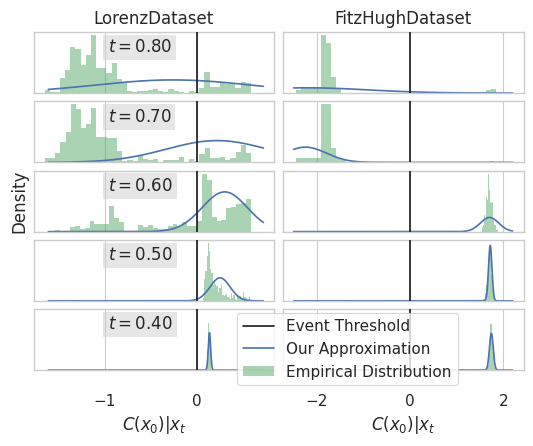

In [167]:
datasets = ['LorenzDataset','FitzHughDataset']
import matplotlib.transforms as mtransforms

#plt.figure(figsize=(4*1.3, 3*1.3))
fig, axs = plt.subplots(5,2, figsize=(1.3*4,1.3*3.3), layout='constrained',sharex='col')
axs[-1,0].set_xlabel(r'$C(x_0)|x_t$')
axs[-1,1].set_xlabel(r'$C(x_0)|x_t$')

for l,ds,ax in zip(range(2),datasets,axs.T):
    ax[0].set_title(ds)
    with open(f'{ds}_gaussian', 'rb') as f:
        (Cxts,mu_sigmas,ts) = pickle.load(f)

    X = np.linspace(np.min(Cxts[0]),1.2*np.max(Cxts[0]),500)
    for a,i in zip(ax,[2,3,4,5,6]):
        a.axvline(x=0,color='k',zorder=100)
        a.hist(Cxts[i],bins=40,color='g',density=True,alpha=.5,lw=0.0)
        mu, std = mu_sigmas[i]
        y = norm(loc=mu,scale=std).pdf(X)
        a.plot(X,y,color='b')
        a.set_yticks([])
        if l: continue
        #a.set_ylim(0,1.5*np.max(y))
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        a.text(.25, 1.0, r'$t={:.2f}$'.format(ts[i]), transform=a.transAxes + trans,
                fontsize='medium', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='0.9', edgecolor='none', pad=3.0),zorder=0)
        
    #a.set_xlim(np.min(Cxts[i]),1.2*np.max(Cxts[i]))
#plt.hist(np.array(ode_samples[:,:timesteps,:2].mean(-1).max(-1)),bins=100,color='g',density=True,alpha=.2)
#plt.hist(np.array(event_constraint(Zs[:4000])),bins=80,color='b',density=True,alpha=.5,lw=0.0)

#plt.yscale('log')
#plt.xlabel(r'$\max_\tau x(\tau)$')
#plt.xlabel(r'$C(x)$')
axs[(len(ax))//2,0].set_ylabel('Density')
#plt.ylim(1e-2,2.5)
fig.legend(['Event Threshold',r'Our Approximation',r'Empirical Distribution'],loc='lower right', bbox_to_anchor=(.88,0.1), ncol=1, bbox_transform=fig.transFigure)
plt.savefig('gaussian.pdf', bbox_inches='tight')

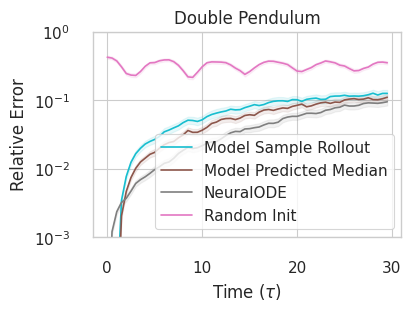

In [165]:
import seaborn as sns



import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS)[5:]
perm = [4,0,2,3,1]
colors=[colors[perm[i]] for i in range(len(perm))]
datasets = ["LorenzDataset","FitzHughDataset", "NPendulum"]
names = ['Double Pendulum']
T = np.linspace(0,1,60) #TODO get real T
fig, ax = plt.subplots(1,1, figsize=(4,3), layout='constrained',sharey=True)
ax = (ax,)
ax[0].set_ylabel('Relative Error')
for a,dataset,i in zip(ax,datasets[-1:],range(3)):
    a.set_ylim(1e-3,1)
    a.set_yscale('log')
    a.set_xlabel(r'Time $(\tau)$')
    a.set_title(names[i])
    with open(f'{dataset}_Zs', 'rb') as f:
        (T_long,trajectories,test_x) = pickle.load(f)
    with open(f'{dataset}_rollouts2', 'rb') as f:
        data_dict = pickle.load(f)
    for k,(name, vals) in enumerate(data_dict.items()):
        if k==3: 
            continue
        rel_errs,rel_stds = vals
        a.plot(T_long-T_long[0],rel_errs,label=name,color=colors[k])
        a.fill_between(T_long-T_long[0], rel_errs/rel_stds, rel_errs*rel_stds,alpha=.1,color=colors[k])
        
    if i==1: a.legend() 
handles, labels = ax[0].get_legend_handles_labels()
labels[0] = "Model Sample Rollout"
labels[1]="Model Predicted Median"
ax[0].legend(handles,labels)
plt.savefig('rollouts_median.pdf') 

[-15.261919]
[-2.6141229]
[-0.26142216]
[0.21277604]
[0.2956218]
[0.24509662]
[0.13121837]
[0.11391339]
[0.113206]
[0.11083224]


Text(0, 0.5, 'CDF')

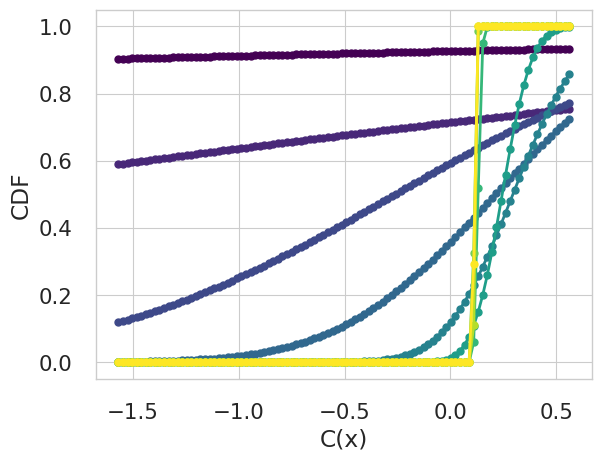

In [60]:


Ts = np.linspace(0,1,len(ts))
colors = plt.cm.viridis(Ts)
#plt.set_cmap('jet')
#plt.plot(np.arange(binvals.shape[0]),binvals)
for t,ms,cs,c in zip(ts,mu_sigmas,Cxts,colors):
    mu,sigma = ms
    X = np.linspace(np.min(Cxts[0]),np.max(Cxts[0]),100)
    gY = norm.cdf((X-mu)/sigma)
    #plt.plot(X,gY,marker='.',color=c,markersize=10,lw=2)
    Y2 = (np.arange(100)+.5)/100
    X2 = np.sort(cs)
    plt.plot(X2,Y2,marker='.',color=c,markersize=10,lw=2)
    #plt.plot((1+np.arange(agg_binvals.shape[0]))/10,bval,color=c,alpha=.5,lw=2)
#plt.plot((1+np.arange(agg_binvals.shape[0]))/10,(1+np.arange(agg_binvals.shape[0]))/10.,'--',lw=3,color='k')
plt.xlabel('C(x)')
plt.ylabel('CDF')

#plt.legend([r"$\tau\in({:.2g},{:.2g})$".format(tt[-1]*a/10,tt[-1]*b/10) for (a,b) in zip(range(10),range(1,11))]+['Optimal'],bbox_to_anchor=(1.4, .5), loc='center right', ncol=1)
#plt.savefig('quantiles.pdf', bbox_inches='tight')

Text(0, 0.5, 'CDF')

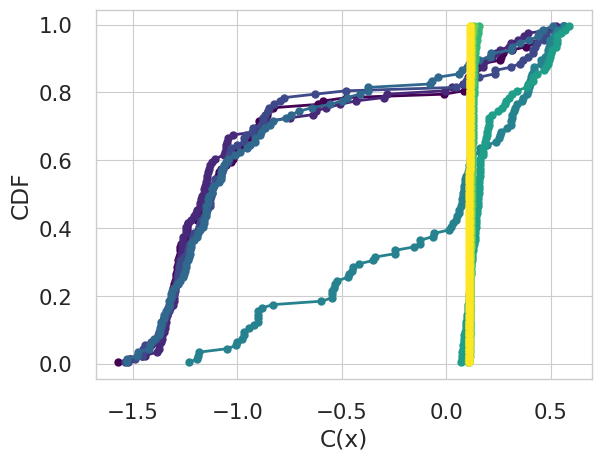

In [61]:
#plt.plot(np.arange(binvals.shape[0]),binvals)
for t,ms,cs,c in zip(ts,mu_sigmas,Cxts,colors):
    mu,sigma = ms
    X = np.linspace(np.min(Cxts[0]),np.max(Cxts[0]),100)
    gY = norm.cdf((X-mu)/sigma)
    #plt.plot(X,gY,marker='.',color=c,markersize=10,lw=2)
    Y2 = (np.arange(100)+.5)/100
    X2 = np.sort(cs)
    plt.plot(X2,Y2,marker='.',color=c,markersize=10,lw=2)
    #plt.plot((1+np.arange(agg_binvals.shape[0]))/10,bval,color=c,alpha=.5,lw=2)
#plt.plot((1+np.arange(agg_binvals.shape[0]))/10,(1+np.arange(agg_binvals.shape[0]))/10.,'--',lw=3,color='k')
plt.xlabel('C(x)')
plt.ylabel('CDF')

In [50]:
completions.shape

(100, 60, 3)

In [51]:
mu,std = mu_std(x_start[:1],timestep)

In [52]:
mu,std

(DeviceArray([-2.6141229], dtype=float32),
 DeviceArray([4.624146], dtype=float32))

(array([17., 43.,  8.,  5.,  4.,  2.,  1.,  5., 10.,  5.]),
 array([-1.52314198, -1.31838369, -1.11362529, -0.90886694, -0.7041086 ,
        -0.49935025, -0.2945919 , -0.08983356,  0.11492479,  0.31968313,
         0.52444148]),
 <BarContainer object of 10 artists>)

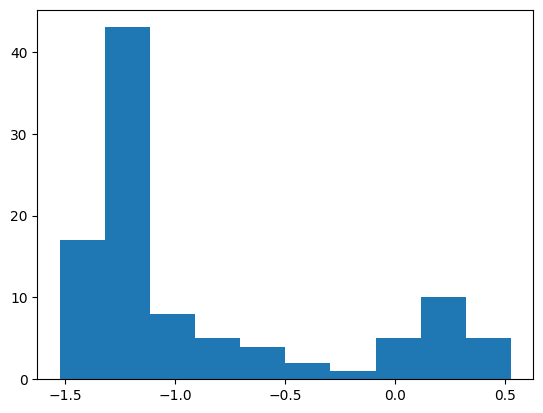

In [53]:
Cxt = lorenz_C(completions)
plt.hist(Cxt)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
#rc('text', usetex=True)
#rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('xtick.major', pad=12)
rc('ytick.major', pad=12)
rc('grid', linewidth=1.3)

sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.75)

Ts = np.linspace(0,1,agg_binvals.shape[1])
colors = plt.cm.viridis(Ts)
#plt.set_cmap('jet')
#plt.plot(np.arange(binvals.shape[0]),binvals)
for bval,c in zip(agg_binvals.T[:],colors):
    plt.plot((1+np.arange(agg_binvals.shape[0]))/10,bval,marker='.',color=c,markersize=10,lw=2)
    #plt.plot((1+np.arange(agg_binvals.shape[0]))/10,bval,color=c,alpha=.5,lw=2)
plt.plot((1+np.arange(agg_binvals.shape[0]))/10,(1+np.arange(agg_binvals.shape[0]))/10.,'--',lw=3,color='k')
plt.xlabel('Model Quantiles')
plt.ylabel('Data Quantiles')

plt.legend([r"$\tau\in({:.2g},{:.2g})$".format(tt[-1]*a/10,tt[-1]*b/10) for (a,b) in zip(range(10),range(1,11))]+['Optimal'],bbox_to_anchor=(1.4, .5), loc='center right', ncol=1)
plt.savefig('quantiles.pdf', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(4*1.3, 3*1.3))
plt.hist(np.array(event_constraint(sde_samples)),bins=80,color='red',density=True,alpha=.5,lw=0.0)
#plt.hist(np.array(ode_samples[:,:timesteps,:2].mean(-1).max(-1)),bins=100,color='g',density=True,alpha=.2)
plt.hist(np.array(event_constraint(Zs[:4000])),bins=80,color='b',density=True,alpha=.5,lw=0.0)

#plt.yscale('log')
#plt.xlabel(r'$\max_\tau x(\tau)$')
#plt.xlabel(r'$C(x)$')
plt.ylabel('Density')
plt.ylim(1e-2,2.5)
plt.axvline(x=0,color='k')
plt.legend(['y cutoff','Diffusion samples','True distribution'])